Colab Notebook Link: [Team9_B](https://colab.research.google.com/drive/1GsFD0aFX6gZq9Lv54vjKJzvGYyARBPLn?usp=chrome_ntp#scrollTo=nwWraUBm2Sue)

# **Conversion Prediction for Digital Marketing Campaigns**
## Team 9 Cohort B: Amisha Kelkar, Manan Goel, Pratik Mahajan, Yashna Meher

## **Introduction**

### **Problem Definition:**

We are working with a dataset which outlines digital marketing campaigns, their types and channels and money spent on them on a customer level. To achieve this, we will be using relevant columns from the dataset and will apply different machine learning models. After training these models on the majority of the data, our objective is to make accurate predictions on the "Conversion" column.

This is achieved by preparing the data and then experimenting with multiple machine learning models, further fine tuning them to account for class imbalance and nuances of the hyperparameters used for each of the models.

### **Data Source:**

We are using a dataset created synthetically for digital marketing campaigns from kaggle
([Kaggle Link for the Dataset details](https://www.kaggle.com/datasets/rabieelkharoua/predict-conversion-in-digital-marketing-dataset)). Since the dataset has limited records, with the objective of
honing our data cleaning skills, we have taken the liberty of adding more synthetic data using GenAI
capabilities.<br>
This dataset was generated for educational purposes, making it ideal for data science and machine learning projects. It is an original dataset, owned by Mr. Rabie El Kharoua, and has not been previously shared.<br>

**Dataset Description**

| Column Name          | Description                                                                   | Data Type |
|-----------------------|-------------------------------------------------------------------------------|-----------|
| **CustomerID**        | Unique identifier for each customer.                                         | Integer   |
| **Age**               | Age of the customer.                                                        | Integer   |
| **Gender**            | Gender of the customer (Male/Female).                                        | Object    |
| **Income**            | Annual income of the customer in USD.                                        | Integer   |
| **CampaignChannel**   | Channel through which the marketing campaign is delivered (e.g., Email, PPC).| Object    |
| **CampaignType**      | Type of the marketing campaign (e.g., Awareness, Conversion).                | Object    |
| **AdSpend**           | Amount spent on the marketing campaign in USD.                              | Float     |
| **ClickThroughRate**  | Rate at which customers click on the marketing content.                      | Float     |
| **ConversionRate**    | Rate at which clicks convert to desired actions (e.g., purchases).           | Float     |
| **WebsiteVisits**     | Number of visits to the website.                                             | Integer   |
| **PagesPerVisit**     | Average number of pages visited per session.                                 | Float     |
| **TimeOnSite**        | Average time spent on the website per visit (in minutes).                   | Float     |
| **SocialShares**      | Number of times the marketing content was shared on social media.            | Integer   |
| **EmailOpens**        | Number of times marketing emails were opened.                               | Integer   |
| **EmailClicks**       | Number of times links in marketing emails were clicked.                     | Integer   |
| **PreviousPurchases** | Number of previous purchases made by the customer.                          | Integer   |
| **LoyaltyPoints**     | Number of loyalty points accumulated by the customer.                       | Integer   |
| **Conversion**        | Binary variable indicating whether the customer converted (1) or not (0).   | Integer   |
| **AdvertisingPlatform** | Confidential.                                                             | Object    |
| **AdvertisingTool**   | Confidential.                                                               | Object    |


## **Data Analysis and Preprocessing**

### **Importing Libraries and Initializing the Environment**

In [ ]:
# Importing the relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform, stats
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from xgboost import XGBClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
import joblib

### **Loading the Dataset**

In [ ]:
df = pd.read_csv('marketing_dataset_with_random_nulls.csv')

### **Exploratory Data Analysis**

**Percentage of Missing values**

The bar chart shows the percentage of missing values across dataset columns. Columns like `Age`, `Gender` and `CampaignChannel` show around 6-7% missing data, while the target column `Conversion` has no missing values. Columns with significant missing values, such as `AdSpend`, require preprocessing, like imputation or handling strategies, to ensure data quality.

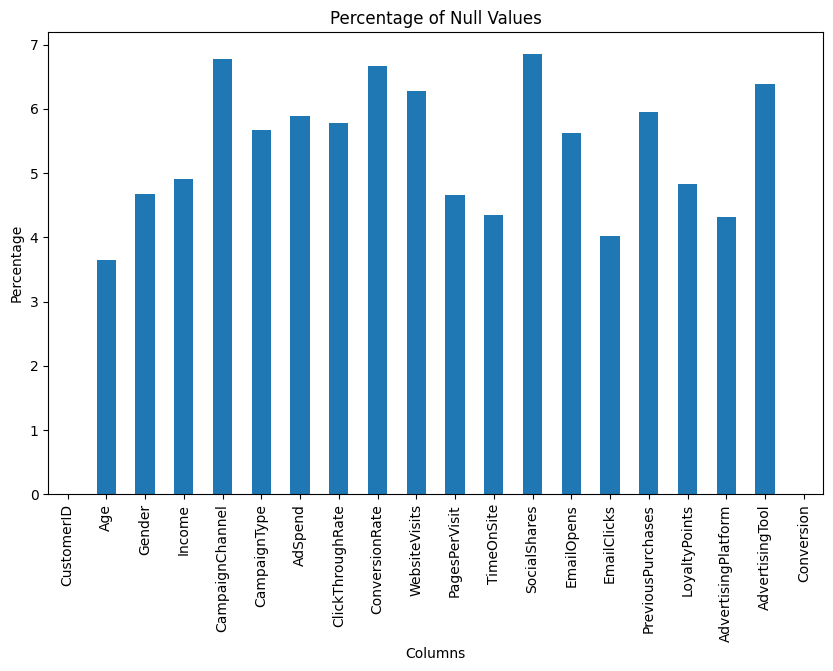

In [ ]:
null = df.isnull().sum() / len(df) * 100

# Plotting the percentage of null values as a bar chart
plot = null.plot(kind='bar', figsize=(10, 6))
plot.set_title("Percentage of Null Values")
plot.set_xlabel("Columns")
plot.set_ylabel("Percentage")
plt.show()

**Relationship Between Ad Spend and Conversion**


The KDE plot compares the distribution of AdSpend for converted (orange) and non-converted (blue) customers. The orange curve indicates that higher ad spend is associated with conversions. There is a major class imbalance in the target variable.

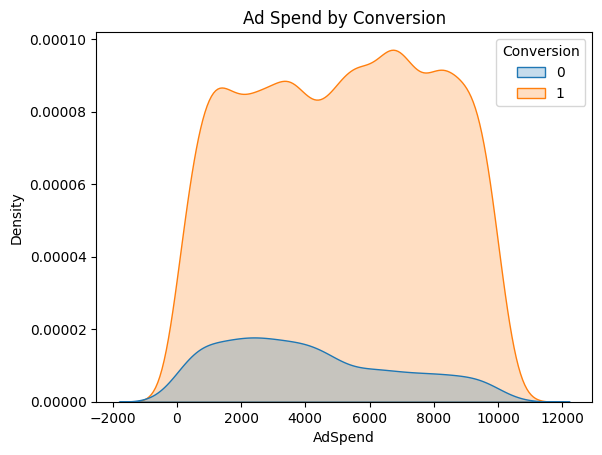

In [ ]:
# KDE plot
sns.kdeplot(data=df, x='AdSpend', hue='Conversion', fill=True)
plt.title('Ad Spend by Conversion')
plt.show()


**Correlation with conversion**

Customer engagement metrics like `TimeOnSite`, `EmailOpens` and `EmailClicks` show strong positive correlations with conversions, indicating their importance in driving outcomes. `AdSpend` also correlates positively, emphasizing the role of investment in ads. Conversely, features like `Income` and `Age` have minimal impact, making them less critical for predictive modeling.

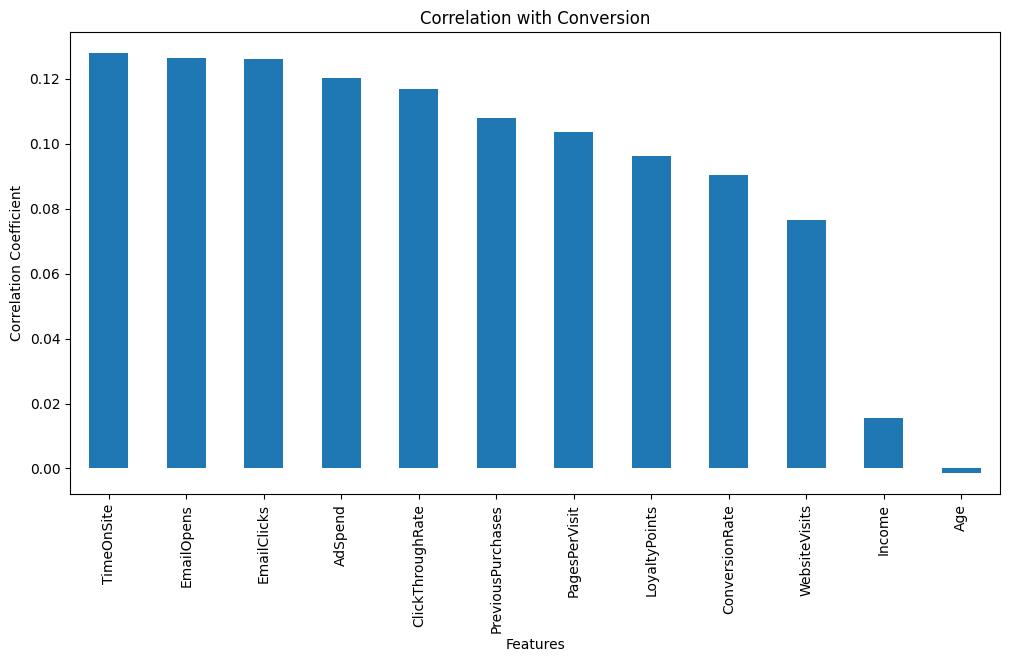

In [ ]:
numerical_features = df.select_dtypes(include=['int64', 'float64'])

# Calculating correlation with 'Conversion' for numerical features
corr_with_target = numerical_features.corr()['Conversion'].sort_values(ascending=False)


corr_with_target = corr_with_target[1:-2]

# Plotting the correlations
corr_with_target.plot(kind='bar', figsize=(12, 6))
plt.title('Correlation with Conversion')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.show()


### **Preprocessing**

The data was preprocessed for model training. We used the code to remove 'AdvertisingPlatform' and 'AdvertisingTool' columns using the drop() method. We separated the features and target: created a feature set X by dropping 'Conversion' and 'CustomerID' columns, and the target variable y by copying the 'Conversion' column.
<br>Further, the code uses train_test_split to divide the data into training and testing sets, allocating 80% to training and the rest 20% for testing. The random_state=0 ensures consistent results across.

In [ ]:
df.drop(['AdvertisingPlatform','AdvertisingTool'],axis=1,inplace=True)

X = df.drop(columns=['Conversion', 'CustomerID'])
y = df["Conversion"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

We created four different pipelines as follows:
1. The cat_pipeline processes categorical features by imputing missing values with the most frequent category and then it encods them using one-hot encoding for categorical data.
2. The log_pipeline deals with the numerical features such as Income. It applies iterative imputation to fill missing values and logarithmic transformation for reducing skewness and standard scaling to normalize the data.
3. A custom pipeline we created is the ratio_pipeline which calculates engagement_ratio by combining metrics like PagesPerVisit, TimeOnSite and others using a formula. Missing values are imputed, and the resulting feature is standardized.
4. Another pipeline, default_num_pipeline, was created to preprocess the other columns by imputing the nulls using the Iterative Imputer and the data was standardized using Standard Scaler.

Finally, these pipelines are integrated into a ColumnTransformer, which applies the engagement_ratio, log_pipeline, and cat_pipeline to their respective columns while processing remaining numerical features with our default pipeline. This ensures consistent and comprehensive preprocessing of all columns.

In [ ]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
  )
log_pipeline = make_pipeline(
    IterativeImputer(),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
def ratio(X):
    a = X[:, 0]  # PagesPerVisit
    b = X[:, 1]  # TimeOnSite
    c = X[:, 2]  # SocialShares
    d = X[:, 3]  # EmailClicks
    e = X[:, 4]  # EmailOpens
    f = X[:, 5]  # WebsiteVisits
    f = np.where(f == 0, 1e-8, f)
    result = ((a * b) + (c / f) + (d / f)) / ((a + b + c + d + e) / f)
    return result.reshape(-1, 1)
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

ratio_pipeline = make_pipeline(
    IterativeImputer(),
    FunctionTransformer(ratio, feature_names_out=ratio_name),
    StandardScaler()
)
default_num_pipeline = make_pipeline(IterativeImputer(), StandardScaler())
preprocessing = ColumnTransformer([
        ("engagement_ratio", ratio_pipeline, ["PagesPerVisit", "TimeOnSite", "SocialShares", "EmailClicks", "EmailOpens", "WebsiteVisits"]),
        ("log", log_pipeline, ["Income"]),
        ("cat", cat_pipeline, ["Gender", "CampaignChannel", "CampaignType"]),
    ],
    remainder=default_num_pipeline, force_int_remainder_cols=False
)
preprocessing

ColumnTransformer(force_int_remainder_cols=False,
                  remainder=Pipeline(steps=[('iterativeimputer',
                                             IterativeImputer()),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('engagement_ratio',
                                 Pipeline(steps=[('iterativeimputer',
                                                  IterativeImputer()),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x782b20311990>,
                                                                      func=<fun...
                                                  IterativeImputer()),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Income']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender', 'CampaignChannel',
                                  'CampaignType'])])

In [ ]:
# Viewing the data
df.describe()

,CustomerID,Age,Income,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
count,16000.000000,15417.000000,15215.000000,15059.000000,15076.000000,14934.000000,14996.000000,15254.000000,15305.000000,14904.000000,15099.000000,15357.000000,15048.000000,15227.000000,16000.000000
mean,11999.500000,43.618473,84652.753073,5004.353310,0.155020,0.104318,24.784603,5.547066,7.738336,49.745035,9.484072,4.475288,4.486443,2490.091942,0.876500
std,2309.473231,14.903177,37608.814420,2847.471298,0.084247,0.055252,14.358668,2.606294,4.229896,28.887188,5.707124,2.854370,2.888910,1427.805408,0.329021
min,8000.000000,18.000000,20014.000000,0.000000,0.000000,0.000000,0.000000,1.000428,0.501669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9999.750000,31.000000,51578.000000,2551.670398,0.082800,0.056200,12.604047,3.302402,4.074414,25.000000,5.000000,2.000000,2.000000,1257.000000,1.000000
50%,11999.500000,43.000000,85020.000000,4993.900351,0.154800,0.103900,24.747589,5.533647,7.693041,50.000000,9.000000,4.000000,4.000000,2501.000000,1.000000
75%,13999.250000,56.000000,116794.000000,7417.993038,0.228200,0.151700,37.060605,7.831853,11.495551,75.000000,14.000000,7.000000,7.000000,3699.000000,1.000000
max,15999.000000,69.000000,149986.000000,10742.880430,0.332200,0.216900,53.467929,9.999055,14.995311,99.000000,19.000000,9.000000,9.000000,4999.000000,1.000000


In [ ]:
# Viewing the data
print(X_train.shape)
X_train_prepared = preprocessing.fit_transform(X_train)
print(X_train_prepared.shape)

(12800, 16)
(12800, 19)


In [ ]:
# Viewing the transformed data
X_train_prepared_df = pd.DataFrame(X_train_prepared,
                                   columns=preprocessing.get_feature_names_out(),
                                   index=X_train.index
                                  )
X_train_prepared_df.head()

,engagement_ratio__ratio,log__Income,cat__Gender_Female,cat__Gender_Male,cat__CampaignChannel_Email,cat__CampaignChannel_PPC,cat__CampaignChannel_Referral,cat__CampaignChannel_SEO,cat__CampaignChannel_Social Media,cat__CampaignType_Awareness,cat__CampaignType_Consideration,cat__CampaignType_Conversion,cat__CampaignType_Retention,remainder__Age,remainder__AdSpend,remainder__ClickThroughRate,remainder__ConversionRate,remainder__PreviousPurchases,remainder__LoyaltyPoints
4683,0.768001,-0.099725,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.023351,0.750873,0.668440,1.230792,-0.172361,-1.666083
15779,-0.838775,0.147126,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.397590,-1.679259,-1.470638,0.185093,-1.596426,-0.519525
6155,-0.066054,1.321794,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.568901,-1.313934,-1.506750,0.956786,0.183655,-0.745125
10824,0.277012,0.619065,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.709993,-1.417299,-0.498001,-0.886702,-1.240410,0.472825
10273,-0.412841,-0.146120,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.568901,1.002700,1.367824,-0.049799,1.607719,-1.661799



## **Model Training**

### **Model Evaluation Metric**

We used this code to define a function print_scores to evaluate and display the performance of a machine learning model using key classification metrics. It takes the true labels (y_test) and predicted labels (y_pred) as inputs and calculates metrics such as accuracy, balanced accuracy, precision, recall and F1-score.

Additionally, the function uses ConfusionMatrixDisplay to create a confusion matrix that provides insights into the model's performance in correctly predicting classes.



In [ ]:
def print_scores(y_test, y_pred):
  plt.rc("font", size=20)
  cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues, colorbar=False)
  accuracy = accuracy_score(y_test, y_pred)
  balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
  print(f'Accuracy={accuracy:.4f}, Balanced Accuracy={balanced_accuracy:.4f}')
  precision = precision_score(y_test, y_pred, pos_label=1)
  recall = recall_score(y_test, y_pred, pos_label=1)
  f1 = f1_score(y_test, y_pred, pos_label=1)
  print(f'Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}')


### **Logistic Regression Classifier**


The logistic regression model achieved a balanced accuracy of 65.7% and an F1-score of 76.99%. While precision is at 92.66%, the recall is of 65.85% suggests the model struggles to identify all positive cases. The confusion matrix highlights a significant number of false negatives (949), indicating room for improvement in capturing true conversions.

In [ ]:
# Creating a logistic regression pipeline

lr_pipe = make_pipeline(preprocessing, LogisticRegression(class_weight='balanced'))
lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('iterativeimputer',
                                                              IterativeImputer()),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('engagement_ratio',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'CampaignChannel',
                                                   'CampaignType'])])),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced'))])

Accuracy=0.6581, Balanced Accuracy=0.6570
Precision=0.9266, Recall=0.6585, F1-score=0.7699


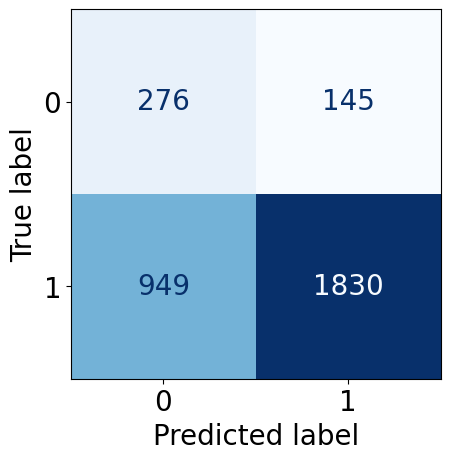

In [ ]:
# Displaying performance metrics

y_pred = lr_pipe.predict(X_test)
print_scores(y_test, y_pred)

### **XGBoost Classifier**


The XGBoost classifier achieved high overall performance, with an accuracy of 90.22% and a balanced accuracy of 67.16%, indicating effective handling of the class imbalance. The precision (91.02%) and recall (98.45%) highlight its ability to minimize false positives while correctly identifying most positive cases, resulting in a strong F1-score of 94.59%. This makes XGBoost a robust choice for improving predictive power over logistic regression. The confusion matrix further demonstrates the model's strong ability to classify positive cases accurately, with some misclassifications in the negative class.

In [ ]:
# Creating a XGBoost pipeline
xgb_pipe = make_pipeline(preprocessing, XGBClassifier(eval_metric='logloss'))
xgb_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('iterativeimputer',
                                                              IterativeImputer()),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('engagement_ratio',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Accuracy=0.9022, Balanced Accuracy=0.6716
Precision=0.9102, Recall=0.9845, F1-score=0.9459


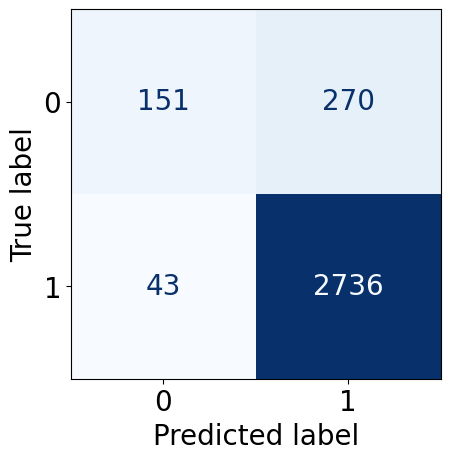

In [ ]:
# Displaying performance metrics

y_pred =xgb_pipe.predict(X_test)
print_scores(y_test, y_pred)

### **Decision Tree Classifier**



The Decision Tree classifier, trained with class balancing, achieved an accuracy of 87.12% and a balanced accuracy of 69.31%, effectively addressing class imbalance. The precision of 91.83% and recall of 93.49% demonstrate its ability to minimize false positives while accurately identifying positive cases, resulting in a strong F1-score of 92.65%. The confusion matrix reflects improved classification across both classes compared to logistic regression, though there is still room for refinement in the misclassification rates.

In [ ]:
# Creating a Decision Tree pipeline

dt_pipe = make_pipeline(preprocessing, DecisionTreeClassifier(class_weight='balanced'))
dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('iterativeimputer',
                                                              IterativeImputer()),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('engagement_ratio',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'CampaignChannel',
                                                   'CampaignType'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

Accuracy=0.8712, Balanced Accuracy=0.6931
Precision=0.9183, Recall=0.9349, F1-score=0.9265


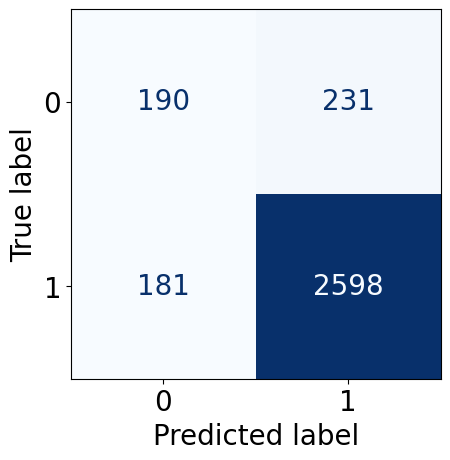

In [ ]:
# Displaying performance metrics

y_pred =dt_pipe.predict(X_test)
print_scores(y_test, y_pred)

### **Random Forest Classifier**

The Random Forest classifier, trained with balanced class weights, achieved an accuracy of 90.38% and a balanced accuracy of 63.92%, showing strong overall performance but room for improvement in class imbalance handling. With a precision of 90.15% and an impressive recall of 99.82%, the model excels at minimizing false negatives while maintaining a solid F1-score of 94.74%. The confusion matrix highlights its exceptional performance in identifying positive cases, with very few misclassifications for this class.

In [ ]:
# Creating a Random Forest pipeline

rf_pipe = make_pipeline(preprocessing, RandomForestClassifier(class_weight='balanced'))
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder=Pipeline(steps=[('iterativeimputer',
                                                              IterativeImputer()),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('engagement_ratio',
                                                  Pipeline(steps=[('iterativeimputer',
                                                                   IterativeImputer()),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function...
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'CampaignChannel',
                                                   'CampaignType'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced'))])

Accuracy=0.9038, Balanced Accuracy=0.6392
Precision=0.9015, Recall=0.9982, F1-score=0.9474


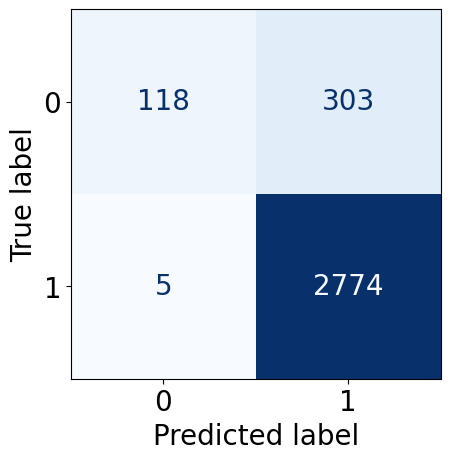

In [ ]:
# Displaying performance metrics

y_pred = rf_pipe.predict(X_test)
print_scores(y_test, y_pred)

## **Feature Selection & Hyperparameter Tuning**

### **Logistic Regression Classifier**

**Logistic Regression with Forward Feature Selection and Randomized Hyperparameter Tuning**

This code combines forward feature selection with randomized hyperparameter tuning to optimize a Logistic Regression model for balanced accuracy.

Sequential Forward Selection (SFS) identifies the best subset of features by evaluating combinations through cross-validated balanced accuracy, while RandomizedSearchCV explores a broader range of hyperparameter values (C and penalty type) efficiently.

The best parameters identified were C=0.6502 and penalty='l1', resulting in a balanced accuracy of 67.91%. The selected features include key engagement metrics (engagement_ratio__ratio), categorical variables such as cat__Gender_Female and cat__CampaignChannel_Social Media, and numerical predictors like remainder__AdSpend and remainder__ClickThroughRate.

This approach highlights the importance of combining both categorical and numerical features, as well as engagement indicators, for improving the model's generalization. Randomized search offers an efficient alternative to grid search, maintaining strong performance while covering a wider hyperparameter space.


In [ ]:
# Defining Logistic Regression Classifier
lr_pipe = LogisticRegression(class_weight="balanced", random_state=0,solver="liblinear")

# Defining scorer
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

# Defining parameter grid
param_grids = {
    "model__C": [0.1, 1, 10],
    "model__penalty": ["l1", "l2"]}

# Feature Selection
sfs_lr_forward = SequentialFeatureSelector(
    lr_pipe, k_features="best", scoring=balanced_accuracy_scorer, forward=True, cv=5
)

# Building Pipeline
lr_pipe_sfs = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", sfs_lr_forward),
    ("model", lr_pipe)
])

# GridSearchCV
grid_search = GridSearchCV(
    lr_pipe_sfs, param_grids, scoring="balanced_accuracy", cv=5
)
grid_search.fit(X_train, y_train)

# Displaying results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best balanced accuracy: {grid_search.best_score_:.4f}")


selected_features_lr_forward = grid_search.best_estimator_.named_steps['feature_selection'].k_feature_names_
print("Selected features for LR Forward + GridSearch:", selected_features_lr_forward)
# Extracting selected feature names
selected_feature_indexes = grid_search.best_estimator_.named_steps["feature_selection"].k_feature_idx_

# Handling preprocessing feature names
if hasattr(preprocessing, "get_feature_names_out"):
    feature_names = preprocessing.get_feature_names_out()
else:
    feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(X_train.shape[1])

selected_feature_names = [feature_names[i] for i in selected_feature_indexes]
print("Selected features:", selected_feature_names)

# Creating Model
lr_forward_grid_tuned = LogisticRegression(
    C=grid_search.best_params_["model__C"],
    penalty=grid_search.best_params_["model__penalty"],
    class_weight="balanced",
    random_state=0
)

lr_forward_grid_tuned_model=make_pipeline(preprocessing, lr_forward_grid_tuned)

original_feature_names = [X_train.columns[int(name.split('_')[0])] for name in selected_feature_names if name.split('_')[0].isdigit()]

# Selecting transformed features using original feature names
X_train_lr_forward_grid = X_train[original_feature_names]
X_test_lr_forward_grid = X_test[original_feature_names]


Best parameters: {'model__C': 0.1, 'model__penalty': 'l2'}
Best balanced accuracy: 0.6799
Selected features for LR Forward + GridSearch: ('0', '4', '5', '8', '9', '11', '14', '15', '16', '17', '18')
Selected features: ['engagement_ratio__ratio', 'cat__CampaignChannel_Email', 'cat__CampaignChannel_PPC', 'cat__CampaignChannel_Social Media', 'cat__CampaignType_Awareness', 'cat__CampaignType_Conversion', 'remainder__AdSpend', 'remainder__ClickThroughRate', 'remainder__ConversionRate', 'remainder__PreviousPurchases', 'remainder__LoyaltyPoints']


**Logistic Regression with Forward Feature Selection and Randomized Hyperparameter Tuning**

This code combines forward feature selection with randomized hyperparameter tuning to optimize a Logistic Regression model for balanced accuracy. Sequential Forward Selection (SFS) identifies the best subset of features by evaluating combinations through cross-validated balanced accuracy, while RandomizedSearchCV explores a broader range of hyperparameter values (C and penalty type) efficiently. The best parameters identified were C=0.6502 and penalty='l1', resulting in a balanced accuracy of 67.91%. The selected features include key engagement metrics (engagement_ratio__ratio), categorical variables such as cat__Gender_Female and cat__CampaignChannel_Social Media, and numerical predictors like remainder__AdSpend and remainder__ClickThroughRate. This approach highlights the importance of combining both categorical and numerical features, as well as engagement indicators, for improving the model's generalization. Randomized search offers an efficient alternative to grid search, maintaining strong performance while covering a wider hyperparameter space.




In [ ]:
# Defining Logistic Regression Classifier
lr_pipe = LogisticRegression(class_weight="balanced", random_state=0,solver="liblinear")

# Defining a scorer for balanced accuracy
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)

# Defining parameter distributions for randomized search
param_distributions = {
    "model__C": stats.loguniform(0.001, 50),  # Randomly sample from a wide range
    "model__penalty": ["l1", "l2"],

}

# Sequential Feature Selection
sfs = SequentialFeatureSelector(lr_pipe, k_features="best", scoring=balanced_accuracy_scorer, forward=True, cv=3)

# Building pipeline
lr_pipe_sfs = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", sfs),
    ("model", lr_pipe)
])

# Randomized search for hyperparameter tuning
random_search = RandomizedSearchCV(
    lr_pipe_sfs,
    param_distributions,
    scoring="balanced_accuracy",
    cv=3,
    n_iter=20,
    random_state=42
)
random_search.fit(X_train, y_train)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best balanced accuracy: {random_search.best_score_:.4f}")

selected_features_lr_forward = random_search.best_estimator_.named_steps['feature_selection'].k_feature_names_
print("Selected features for LR Forward + Random Search:", selected_features_lr_forward)
# Extracting selected feature names
selected_feature_indexes = random_search.best_estimator_.named_steps["feature_selection"].k_feature_idx_

# Handling preprocessing feature names
if hasattr(preprocessing, "get_feature_names_out"):
    feature_names = preprocessing.get_feature_names_out()
else:
    feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(X_train.shape[1])

selected_feature_names = [feature_names[i] for i in selected_feature_indexes]
print("Selected features:", selected_feature_names)

# Creating Model
lr_forward_random_tuned = LogisticRegression(
    C=random_search.best_params_["model__C"],
    penalty=random_search.best_params_["model__penalty"],
    class_weight="balanced",
    random_state=0
)

lr_forward_random_tuned_model=make_pipeline(preprocessing, lr_forward_random_tuned)
original_feature_names = [X_train.columns[int(name.split('_')[0])] for name in selected_feature_names if name.split('_')[0].isdigit()]

# Selecting transformed features
X_train_lr_forward_random = X_train[original_feature_names]
X_test_lr_forward_random = X_test[original_feature_names]



Best parameters: {'model__C': 0.6502468545951017, 'model__penalty': 'l1'}
Best balanced accuracy: 0.6791
Selected features for LR Forward + Random Search: ('0', '2', '8', '10', '11', '14', '15', '16', '17', '18')
Selected features: ['engagement_ratio__ratio', 'cat__Gender_Female', 'cat__CampaignChannel_Social Media', 'cat__CampaignType_Consideration', 'cat__CampaignType_Conversion', 'remainder__AdSpend', 'remainder__ClickThroughRate', 'remainder__ConversionRate', 'remainder__PreviousPurchases', 'remainder__LoyaltyPoints']


**Logistic Regression with Backward Feature Selection and Randomized Hyperparameter Tuning**

This code leverages backward feature selection combined with randomized hyperparameter tuning to optimize a Logistic Regression model for balanced accuracy. Sequential Backward Selection (SBS) begins with all features and iteratively removes the least significant ones based on cross-validated balanced accuracy.

Simultaneously, RandomizedSearchCV explores a wide hyperparameter space for regularization strength (C) and penalty type (l1, l2) to efficiently identify optimal settings. The best parameters identified were C=0.0575 and penalty='l1', achieving a balanced accuracy of 68.06%. The selected features include engagement metrics (engagement_ratio__ratio), transformed numerical features (log__Income), categorical predictors such as cat__CampaignChannel_SEO and cat__CampaignType_Conversion, and critical numerical attributes like remainder__AdSpend and remainder__ClickThroughRate.

This approach balances interpretability and performance by retaining 12 essential features, emphasizing the importance of diverse variables for robust model predictions. Randomized search further ensures computational efficiency while maintaining strong model performance.


In [ ]:
sfs_backward = SequentialFeatureSelector(
    lr_pipe, k_features="best", scoring=balanced_accuracy_scorer, forward=False, cv=3
)

# Building pipeline with backward feature selection
lr_pipe_sfs = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", sfs_backward),
    ("model", lr_pipe)
])

# Randomized search with backward feature selection
random_search = RandomizedSearchCV(
    lr_pipe_sfs,
    param_distributions,
    scoring="balanced_accuracy",
    cv=3,
    n_iter=20,
    random_state=42
)
random_search.fit(X_train, y_train)

# Displaying best results
print("\nRandomized Search with Backward Feature Selection")
print(f"Best parameters for Logistic Regression: {random_search.best_params_}")
print(f"Best balanced accuracy for Logistic Regression: {random_search.best_score_:.4f}")

selected_features_lr_backward = random_search.best_estimator_.named_steps['feature_selection'].k_feature_names_
print("Selected features for LR Backward + Random Search:", selected_features_lr_backward)

selected_feature_indexes = random_search.best_estimator_.named_steps["feature_selection"].k_feature_idx_

# Handling preprocessing feature names
if hasattr(preprocessing, "get_feature_names_out"):
    feature_names = preprocessing.get_feature_names_out()
else:
    feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(X_train.shape[1])

selected_feature_names = [feature_names[i] for i in selected_feature_indexes]
print("Selected features:", selected_feature_names)

# Creating Model
lr_backward_random_tuned = LogisticRegression(
    C=random_search.best_params_["model__C"],
    penalty=random_search.best_params_["model__penalty"],
    class_weight="balanced",
    random_state=0
)
lr_backward_random_tuned_model=make_pipeline(preprocessing, lr_backward_random_tuned)
original_feature_names = [X_train.columns[int(name.split('_')[0])] for name in selected_feature_names if name.split('_')[0].isdigit()]

# Selecting transformed features
X_train_lr_backward_random = X_train[original_feature_names]
X_test_lr_backward_random = X_test[original_feature_names]




Randomized Search with Backward Feature Selection
Best parameters for Logistic Regression: {'model__C': 0.057537737941171875, 'model__penalty': 'l1'}
Best balanced accuracy for Logistic Regression: 0.6806
Selected features for LR Backward + Random Search: ('0', '1', '5', '7', '9', '11', '12', '14', '15', '16', '17', '18')
Selected features: ['engagement_ratio__ratio', 'log__Income', 'cat__CampaignChannel_PPC', 'cat__CampaignChannel_SEO', 'cat__CampaignType_Awareness', 'cat__CampaignType_Conversion', 'cat__CampaignType_Retention', 'remainder__AdSpend', 'remainder__ClickThroughRate', 'remainder__ConversionRate', 'remainder__PreviousPurchases', 'remainder__LoyaltyPoints']


**Logistic Regression with Backward Feature Selection and Grid Hyperparameter Tuning**

This code uses backward feature selection and grid search to fine-tune a Logistic Regression model for balanced accuracy. Sequential Backward Selection (SBS) starts with all features and systematically removes the least significant ones, optimizing the feature subset using cross-validated balanced accuracy as the metric.

Concurrently, GridSearchCV tests various combinations of regularization strength (C) and penalty type (l1, l2) to determine the best model configuration. The optimal parameters were identified as C=0.1 and penalty='l1', yielding a balanced accuracy of 68.14%. The selected features include a comprehensive mix of engineered metrics (engagement_ratio__ratio), categorical variables (cat__CampaignChannel_PPC, cat__CampaignType_Conversion), and numerical predictors (remainder__AdSpend, remainder__ClickThroughRate).

By retaining 16 essential features, this approach ensures a robust yet interpretable model that effectively balances predictive power and feature relevance. Grid search provides precise hyperparameter optimization, making this model highly reliable for classification tasks.

In [ ]:
param_grids = {
    "model__C": [0.1, 1, 10, 100],
    "model__penalty": ["l1", "l2"],
}

# Backward Feature Selector
sfs_backward = SequentialFeatureSelector(
    lr_pipe, k_features="best", scoring=balanced_accuracy_scorer, forward=False, cv=5
)

# Building pipeline with backward feature selection
lr_pipe_sfs = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", sfs_backward),
    ("model", lr_pipe)
])

# Grid search with backward feature selection
grid_search = GridSearchCV(
    lr_pipe_sfs,
    param_grids,
    scoring="balanced_accuracy",
    cv=5
)
grid_search.fit(X_train, y_train)

# Displaying best results
print("\nGrid Search with Backward Feature Selection")
print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")
print(f"Best balanced accuracy for Logistic Regression: {grid_search.best_score_:.4f}")


selected_features_lr_backward_grid = grid_search.best_estimator_.named_steps['feature_selection'].k_feature_names_
print("Selected features for LR Backward + Random Search:", selected_features_lr_backward_grid)

selected_feature_indexes = grid_search.best_estimator_.named_steps["feature_selection"].k_feature_idx_

# Handling preprocessing feature names
if hasattr(preprocessing, "get_feature_names_out"):
    feature_names = preprocessing.get_feature_names_out()
else:
    feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(X_train.shape[1])

selected_feature_names = [feature_names[i] for i in selected_feature_indexes]
print("Selected features:", selected_feature_names)

# Creating Model
lr_backward_grid_tuned = LogisticRegression(
    C=grid_search.best_params_["model__C"],
    penalty=grid_search.best_params_["model__penalty"],
    solver="liblinear",
    class_weight="balanced",
    random_state=0
)
lr_backward_grid_tuned_model=make_pipeline(preprocessing, lr_backward_grid_tuned)
original_feature_names = [X_train.columns[int(name.split('_')[0])] for name in selected_feature_names if name.split('_')[0].isdigit()]

# Selecting transformed features
X_train_lr_backward_grid = X_train[original_feature_names]
X_test_lr_backward_grid = X_test[original_feature_names]






Grid Search with Backward Feature Selection
Best parameters for Logistic Regression: {'model__C': 0.1, 'model__penalty': 'l1'}
Best balanced accuracy for Logistic Regression: 0.6814
Selected features for LR Backward + Random Search: ('0', '1', '2', '3', '5', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18')
Selected features: ['engagement_ratio__ratio', 'log__Income', 'cat__Gender_Female', 'cat__Gender_Male', 'cat__CampaignChannel_PPC', 'cat__CampaignChannel_Social Media', 'cat__CampaignType_Awareness', 'cat__CampaignType_Consideration', 'cat__CampaignType_Conversion', 'cat__CampaignType_Retention', 'remainder__Age', 'remainder__AdSpend', 'remainder__ClickThroughRate', 'remainder__ConversionRate', 'remainder__PreviousPurchases', 'remainder__LoyaltyPoints']


**Note**

*Although we ran the logistic regression model with both forward and backward feature selection and the two hyperparameter tunings, for the other three models we have just kept the best combinations of feature selection and hyperparameter tuning. The balanced accuracies for the other combinations were suboptimal hence were not included in the report.*

### **Decision Tree Classifier**

**Decision Tree with Backward Feature Selection and Randomized Hyperparameter Tuning**

This implementation combines backward feature selection with randomized hyperparameter tuning to optimize a Decision Tree classifier for balanced accuracy.

Sequential Backward Selection (SBS) begins with all features and iteratively removes the least significant ones, guided by cross-validated balanced accuracy as the evaluation metric. Simultaneously, RandomizedSearchCV explores a range of hyperparameters, including max_depth, min_samples_split, and criterion (gini or entropy), to identify the best-performing model configuration efficiently.

The optimal parameters were determined as max_depth=25, min_samples_split=8, and criterion='gini', yielding a balanced accuracy of 70.84%. The selected features, which include categorical variables (cat__CampaignType_Awareness, cat__CampaignType_Consideration) and numerical predictors (remainder__PreviousPurchases, remainder__LoyaltyPoints), emphasize the model's reliance on both campaign-specific and historical customer data for classification. This approach ensures a streamlined and effective feature set while leveraging the Decision Tree's interpretability and flexibility to handle complex data relationships.







In [ ]:
# Defining Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=0, class_weight="balanced")

# Defining randomized parameter ranges
param_dist_dt = {
    "model__max_depth": randint(5, 30),          # Random integers between 5 and 30
    "model__min_samples_split": randint(2, 10),  # Random integers between 2 and 10
    "model__criterion": ["gini", "entropy"]      # Random choice from "gini" or "entropy"
}

# Backward Feature Selection
sfs_backward_dt = SequentialFeatureSelector(
    dt, k_features="best", forward=False, scoring=make_scorer(balanced_accuracy_score), cv=3
)

# Building pipeline
dt_pipe_backward = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", sfs_backward_dt),
    ("model", dt)
])

# RandomizedSearchCV with Backward Selection
random_dt = RandomizedSearchCV(
    dt_pipe_backward, param_distributions=param_dist_dt, n_iter=20, scoring="balanced_accuracy", cv=3, random_state=42, n_jobs=-1
)
random_dt.fit(X_train, y_train)

# Displaying best parameters and balanced accuracy
print("\nDT Backward + RandomizedSearch Best Params:", random_dt.best_params_)
print("DT Backward + RandomizedSearch Best Balanced Accuracy:", random_dt.best_score_)

# Extracting selected features
sfs_dt = random_dt.best_estimator_.named_steps["feature_selection"]
selected_features_dt = sfs_dt.k_feature_names_
print("Selected features for DT Backward + RandomizedSearch:", selected_features_dt)


selected_feature_indexes = random_dt.best_estimator_.named_steps["feature_selection"].k_feature_idx_

# Handling preprocessing feature names
if hasattr(preprocessing, "get_feature_names_out"):
    feature_names = preprocessing.get_feature_names_out()
else:
    feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(X_train.shape[1])

selected_feature_names = [feature_names[i] for i in selected_feature_indexes]
print("Selected features:", selected_feature_names)

# Creating Model
dt_tuned_backward_random = DecisionTreeClassifier(
    max_depth=random_dt.best_params_["model__max_depth"],
    min_samples_split=random_dt.best_params_["model__min_samples_split"],
    criterion=random_dt.best_params_["model__criterion"],
    random_state=0)

dt_tuned_backward_random_model=make_pipeline(preprocessing, dt_tuned_backward_random)

# Selecting transformed features
original_feature_names = [X_train.columns[int(name.split('_')[0])] for name in selected_feature_names if name.split('_')[0].isdigit()]

X_train_dt_backward_random = X_train[original_feature_names]
X_test_dt_backward_random = X_test[original_feature_names]



DT Backward + RandomizedSearch Best Params: {'model__criterion': 'gini', 'model__max_depth': 25, 'model__min_samples_split': 8}
DT Backward + RandomizedSearch Best Balanced Accuracy: 0.7083525314304016
Selected features for DT Backward + RandomizedSearch: ('9', '10', '17', '18')
Selected features: ['cat__CampaignType_Awareness', 'cat__CampaignType_Consideration', 'remainder__PreviousPurchases', 'remainder__LoyaltyPoints']


### **Random Forest Classifier**

**Random Forest with Backward Feature Selection and Grid Hyperparameter Tuning**

This code combines backward feature selection with grid search to optimize a Random Forest classifier for balanced accuracy. Sequential Backward Selection (SBS) starts with all features and removes the least significant ones based on balanced accuracy, while GridSearchCV fine-tunes hyperparameters such as n_estimators, max_depth, and min_samples_split to enhance the model's performance.

The best parameters identified were n_estimators=200, max_depth=20, and min_samples_split=2, achieving a balanced accuracy of 68.13%. The selected features—cat__CampaignType_Consideration, remainder__PreviousPurchases, and remainder__LoyaltyPoints—indicate that the model relies on customer purchase history, loyalty metrics, and specific campaign types to make predictions.

This approach effectively narrows the feature set to three critical variables, improving the model's interpretability while leveraging Random Forest's ability to capture complex interactions within the data.

In [ ]:
param_grid_rf = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 20],
    "model__min_samples_split": [2, 5]
}

# Sequential Feature Selector for Backward Selection
sfs_backward_rf = SequentialFeatureSelector(
    RandomForestClassifier(random_state=0), k_features="best", forward=False, scoring="balanced_accuracy", cv=3
)

# Building pipelines for backward selection
rf_pipe_backward = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", sfs_backward_rf),
    ("model", RandomForestClassifier(random_state=0))
])
grid_rf_backward = GridSearchCV(rf_pipe_backward, param_grid_rf, scoring="balanced_accuracy", cv=3, n_jobs=-1)
grid_rf_backward.fit(X_train, y_train)
print("\nRF Backward + GridSearch Best Params:", grid_rf_backward.best_params_)
print("RF Backward + GridSearch Best Balanced Accuracy:", grid_rf_backward.best_score_)


# Extracting selected features
sfs_rf_backward = grid_rf_backward.best_estimator_.named_steps["feature_selection"]
selected_features_rf_forward = sfs_rf_backward.k_feature_names_
print("Selected features for RF Backward + GridSearch:", selected_features_rf_forward)

selected_feature_indexes = grid_rf_backward.best_estimator_.named_steps["feature_selection"].k_feature_idx_

# Handling preprocessing feature names
if hasattr(preprocessing, "get_feature_names_out"):
    feature_names = preprocessing.get_feature_names_out()
else:
    feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(X_train.shape[1])

selected_feature_names = [feature_names[i] for i in selected_feature_indexes]
print("Selected features:", selected_feature_names)

# Creating Model
rf_tuned_backward_grid = RandomForestClassifier(
    n_estimators=grid_rf_backward.best_params_["model__n_estimators"],
    max_depth=grid_rf_backward.best_params_["model__max_depth"],
    min_samples_split=grid_rf_backward.best_params_["model__min_samples_split"],
    class_weight="balanced",
    random_state=0
)
rf_tuned_backward_grid_model=make_pipeline(preprocessing, rf_tuned_backward_grid)

original_feature_names = [X_train.columns[int(name.split('_')[0])] for name in selected_feature_names if name.split('_')[0].isdigit()]

# Selecting transformed features
X_train_rf_backward_grid = X_train[original_feature_names]
X_test_rf_backward_grid = X_test[original_feature_names]



RF Backward + GridSearch Best Params: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 200}
RF Backward + GridSearch Best Balanced Accuracy: 0.6813429096615012
Selected features for RF Backward + GridSearch: ('10', '17', '18')
Selected features: ['cat__CampaignType_Consideration', 'remainder__PreviousPurchases', 'remainder__LoyaltyPoints']


### **XGBoost Classifier**



**XGBoost with Backward Feature Selection and Randomized Hyperparameter Tuning**

This code use backward feature selection in combination with randomized hyperparameter tuning to optimize an XGBoost classifier for balanced accuracy.

Sequential Backward Selection (SBS) starts with all features and iteratively removes the least significant ones, retaining the most impactful predictors for classification. RandomizedSearchCV searches a wide hyperparameter space, optimizing parameters such as learning_rate, max_depth, n_estimators, subsample. The combination with a learning rate of 0.228, a maximum depth of 17, 299 estimators, a subsample ratio of 0.871, and a feature sampling ratio of 0.978, achieved a balanced accuracy of 68.70%. The selected features include critical engagement metrics (engagement_ratio__ratio), customer demographic information (log__Income, cat__Gender_Female), campaign channels (cat__CampaignChannel_Social Media), and numerical predictors such as remainder__AdSpend and remainder__LoyaltyPoints.

This approach highlights XGBoost's ability to handle complex interactions and non-linear relationships while narrowing the feature set to 17 variables for efficient and robust classification.



In [ ]:
# Defining XGBoost Classifier
xgb = XGBClassifier(random_state=0, eval_metric="logloss", tree_method="hist")

# Defining expanded randomized parameter ranges
param_dist_xgb = {
    "model__learning_rate": uniform(0.01, 0.3),  # Random floats between 0.01 and 0.3
    "model__max_depth": randint(3, 20),          # Random integers between 3 and 20
    "model__n_estimators": randint(100, 350),    # Random integers between 100 and 300
    "model__subsample": uniform(0.7, 0.3),       # Subsample ratios between 0.7 and 1.0
    "model__colsample_bytree": uniform(0.7, 0.3) # Feature sampling ratios between 0.7 and 1.0
}

# Backward Feature Selection with optimization
sfs_backward_xgb = SequentialFeatureSelector(
    xgb,
    k_features="best",  # Limit to selecting up to 10 features
    forward=False,
    scoring=make_scorer(balanced_accuracy_score),
    cv=3,  # Reduce cross-validation folds to speed up feature selection
    n_jobs=-1  # Parallelize feature selection
)

# Building pipeline
xgb_pipe_backward = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", sfs_backward_xgb),
    ("model", xgb)
])

# RandomizedSearchCV with Backward Selection
random_xgb = RandomizedSearchCV(
    xgb_pipe_backward,
    param_distributions=param_dist_xgb,
    n_iter=15,
    scoring="balanced_accuracy",
    cv=3,
    random_state=42,
    n_jobs=-1
)
random_xgb.fit(X_train, y_train)

# Displaying best parameters and balanced accuracy
print("\nXGB Backward + RandomizedSearch Best Params:", random_xgb.best_params_)
print("XGB Backward + RandomizedSearch Best Balanced Accuracy:", random_xgb.best_score_)

# Extracting selected features
sfs_xgb = random_xgb.best_estimator_.named_steps["feature_selection"]
selected_features_xgb = sfs_xgb.k_feature_names_
print("Selected features for XGB Backward + RandomizedSearch:", selected_features_xgb)

selected_feature_indexes = random_xgb.best_estimator_.named_steps["feature_selection"].k_feature_idx_

# Handling preprocessing feature names
if hasattr(preprocessing, "get_feature_names_out"):
    feature_names = preprocessing.get_feature_names_out()
else:
    feature_names = X_train.columns if hasattr(X_train, "columns") else np.arange(X_train.shape[1])

selected_feature_names = [feature_names[i] for i in selected_feature_indexes]
print("Selected features:", selected_feature_names)

# Creating Model
xgb_backward_random_tuned = XGBClassifier(
    learning_rate=random_xgb.best_params_["model__learning_rate"],
    max_depth=random_xgb.best_params_["model__max_depth"],
    n_estimators=random_xgb.best_params_["model__n_estimators"],
    model__subsample=random_xgb.best_params_["model__subsample"],
    model__colsample_bytree=random_xgb.best_params_["model__colsample_bytree"],
    random_state=0,
    eval_metric="logloss",
    tree_method="hist"
)
xgb_backward_random_tuned_model=make_pipeline(preprocessing, xgb_backward_random_tuned)

original_feature_names = [X_train.columns[int(name.split('_')[0])] for name in selected_feature_names if name.split('_')[0].isdigit()]

# Selecting transformed features
X_train_rf_forward_grid = X_train[original_feature_names]
X_test_rf_forward_grid = X_test[original_feature_names]




XGB Backward + RandomizedSearch Best Params: {'model__colsample_bytree': 0.9779976597381381, 'model__learning_rate': 0.22818159875692626, 'model__max_depth': 17, 'model__n_estimators': 299, 'model__subsample': 0.8711331923216198}
XGB Backward + RandomizedSearch Best Balanced Accuracy: 0.6869532386357244
Selected features for XGB Backward + RandomizedSearch: ('0', '1', '2', '3', '4', '5', '6', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18')
Selected features: ['engagement_ratio__ratio', 'log__Income', 'cat__Gender_Female', 'cat__Gender_Male', 'cat__CampaignChannel_Email', 'cat__CampaignChannel_PPC', 'cat__CampaignChannel_Referral', 'cat__CampaignChannel_Social Media', 'cat__CampaignType_Consideration', 'cat__CampaignType_Conversion', 'cat__CampaignType_Retention', 'remainder__Age', 'remainder__AdSpend', 'remainder__ClickThroughRate', 'remainder__ConversionRate', 'remainder__PreviousPurchases', 'remainder__LoyaltyPoints']


## **Ensembles**

###**Voting Classifiers with Hard Voting**

This code combines multiple tuned classifiers into a hard-voting ensemble to leverage the strengths of individual models for improved balanced accuracy. The ensemble includes Logistic Regression (backward selection + grid search), Decision Tree (backward selection + randomized search), XGBoost (backward selection + randomized search), and Random Forest (backward selection + grid search).

Hard voting aggregates the predictions from these models, taking the majority vote for the final classification. Individual balanced accuracies of the models range from 64.14% (Random Forest) to 73.15% (XGBoost), with the voting classifier achieving the highest balanced accuracy of 74.65%.

This improvement demonstrates the ensemble's ability to combine diverse model strengths, mitigating individual weaknesses, and enhancing overall predictive performance. By pooling the decisions of well-optimized base classifiers, the voting classifier delivers robust and reliable results, particularly in scenarios with imbalanced data.

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_backward_grid_tuned_model),
        ('dt', dt_tuned_backward_random_model),
        ('xgb', xgb_backward_random_tuned_model),
        ('rf', rf_tuned_backward_grid_model)
    ], voting='hard'

)

# Fitting the Model
voting_clf.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:39:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(force_int_remainder_cols=False,
                                                                 remainder=Pipeline(steps=[('iterativeimputer',
                                                                                            IterativeImputer()),
                                                                                           ('standardscaler',
                                                                                            StandardScaler())]),
                                                                 transformers=[('engagement_ratio',
                                                                                Pipeline(steps=[('iterativeimputer',
                                                                                                 IterativeImputer()),
                                                                                                ('functiontransformer',
                                                                                                 FunctionTran...
                                                                                                ('standardscaler',
                                                                                                 StandardScaler())]),
                                                                                ['Income']),
                                                                               ('cat',
                                                                                Pipeline(steps=[('simpleimputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('onehotencoder',
                                                                                                 OneHotEncoder(handle_unknown='ignore'))]),
                                                                                ['Gender',
                                                                                 'CampaignChannel',
                                                                                 'CampaignType'])])),
                                              ('randomforestclassifier',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      max_depth=20,
                                                                      n_estimators=200,
                                                                      random_state=0))]))])

In [ ]:
# Displaying the balanced accuracy of each individual model in the voting classifier and the overall ensemble

for name, clf in voting_clf.named_estimators_.items():
    y_pred = clf.predict(X_test)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print(f'Balanced accuracy of {name} is {bal_acc:.4f}')

y_pred_voting = voting_clf.predict(X_test)
bal_acc_voting = balanced_accuracy_score(y_test, y_pred_voting)
print(f'The voting classifier gives a balanced accuracy of {bal_acc_voting:.4f}')

Balanced accuracy of lr is 0.6574
Balanced accuracy of dt is 0.6927
Balanced accuracy of xgb is 0.7315
Balanced accuracy of rf is 0.6414
The voting classifier gives a balanced accuracy of 0.7465


###**Voting Classifiers with Soft Voting**

This code utilizes soft voting in an ensemble classifier to combine the strengths of multiple models by weighting their predicted probabilities rather than relying solely on majority voting.

The ensemble includes Logistic Regression, Decision Tree, XGBoost, and Random Forest models, each tuned through backward feature selection and respective optimization methods. Soft voting considers the confidence of each model's predictions, leading to a balanced accuracy of 72.06%. Individual model accuracies range from 65.53% (Logistic Regression) to 92.22% (XGBoost), showcasing the diverse contributions of each model to the ensemble.

The slightly lower balanced accuracy compared to hard voting reflects the impact of imbalanced data, where probability weighting can amplify the influence of overconfident models. Nevertheless, soft voting offers a nuanced approach by integrating probabilistic outputs, providing robustness and improving ensemble flexibility in various classification scenarios.

In [ ]:
# Defining the VotingClassifier with soft voting
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr_backward_grid_tuned_model),
        ('dt', dt_tuned_backward_random_model),
        ('xgb', xgb_backward_random_tuned_model),
        ('rf', rf_tuned_backward_grid_model)
    ],
    voting='soft'
)

# Fitting the VotingClassifier
voting_clf.fit(X_train, y_train)

# Evaluating each base model's accuracy
for name, clf in voting_clf.named_estimators_.items():
    print(f'Accuracy of {name} is {clf.score(X_test, y_test):.4f}')

# Evaluating the VotingClassifier's accuracy
print(f'Balanced accuracy of VotingClassifier (soft): {balanced_accuracy_score(y_test, voting_clf.predict(X_test)):.4f}')


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:39:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of lr is 0.6553
Accuracy of dt is 0.8478
Accuracy of xgb is 0.9222
Accuracy of rf is 0.9041
Balanced accuracy of VotingClassifier (soft): 0.7206


###**Stacking with Random Forest Final Estimator**

This code uses a stacking ensemble classifier to combine the predictions of multiple base models, including Logistic Regression, Decision Tree, XGBoost and Random Forest.

The model is trained using 5-fold cross-validation (cv=5), which gives us good generalization. Our stacking ensemble achieved a balanced accuracy of 80.16%, outperforming individual models and other ensemble methods such as hard and soft voting.

This increase shows that due to stacking, there is a possibility to cross-synthesis of information between multiple classifiers while learning meta-level patterns, which improves general classification performance.

In [ ]:
# Training a stacking ensemble classifier combining multiple models with a Random Forest as the meta-learner using 5-fold cross-validation
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', lr_backward_grid_tuned_model),
        ('dt', dt_tuned_backward_random_model),
        ('xgb', xgb_backward_random_tuned_model),
        ('rf', rf_tuned_backward_grid_model)
    ],
    passthrough=False,
    final_estimator=RandomForestClassifier(random_state=42),
    cv=5
)
stacking_clf.fit(X_train, y_train)

y_pred = stacking_clf.predict(X_test)

# Calculating balanced accuracy
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Balanced Accuracy of Stacking Classifier: {balanced_acc:.4f}")


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:39:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:39:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:39:31] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [23:39:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "model__colsample_bytree", "model__subsample" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/

Balanced Accuracy of Stacking Classifier: 0.8016


* Amongst the ensemble methods, stacking gave the best Balanced Accuracy of 0.8016. This can be used as the final predictive model.

## **Model Persistence**

**Model Persistence for Reusability**

The code saves the final stacking classifier model as a .pkl file using the joblib library. This allows the trained model to be reused for future predictions without retraining.

In [ ]:
final_model = stacking_clf.best_estimator_

joblib.dump(final_model, "digital_marketing_campaign_conversion_prediction.pkl")

# **Challenges**

1. Synthetic Data Characteristics:
The synthetic data's characteristics made it challenging to observe strong correlations or clear logical trends. While this added complexity, it provided an opportunity to test the robustness of the models and preprocessing techniques.
2. Data Augmentation:
Synthetic data was scaled and expanded to match the Kaggle dataset, requiring additional preprocessing and validation.
3. Class Imbalance:
The imbalance in the target variable (conversion) required specialized techniques like class weighting and careful tuning.
4. Computational Complexity:
Individual feature selection and hyperparameter tuning for multiple models were highly time-consuming.
Running models with extensive cross-validation added to the computational load, slowing down the process.
5. Model Tuning Challenges:
Fine-tuning hyperparameters while balancing performance and interpretability required extensive iterations.

Class imbalance was the biggest challenge we faced. To try and solve it, we explored SMOTE-NC and the class weight argument. The models were overfitting with the former so, we decided to go ahead with class weight argument only.

# **Conclusion**

The evaluation of various models for predicting customer conversions reveals consistent improvement in performance across all classifiers after tuning and adjustments, with a final stacked model balanced accuracy of **80.16%**. While the XGBoost Classifier and Decision Tree Classifier showed higher potential in their initial results, this uniformity in final accuracy highlights the importance of preprocessing and optimization. These findings emphasize that multiple models can achieve comparable outcomes when effectively tuned and supported by a well-prepared dataset.

| Name of Model        | Base Model Balanced Accuracy | Best Model Balanced Accuracy | Stacked Model Balanced Accuracy |
|-----------------------|------------------------------|------------------------------|--------------------------|
| Logistic Regression   | 0.6570                        | 0.6814                        | 0.8016                    |
| Decision Tree Classifier        | 0.6931                        | 0.7084                        | 0.8016                    |
| Random Forest Classifier        | 0.6392                        | 0.6813                        | 0.8016                    |
| XGBoost Classifier              | 0.6716                        | 0.6870                        | 0.8016                    |


# **Generative AI Statement**


In completing this project, we have utilized Generative AI tools to assist with various aspects of our work. Below is a detailed account of how these tools were used:

-	Code Review and Debugging: We used GPT-4o to make our code more efficient, resolve syntax errors and add few components.

-	Proofreading and Grammar Checks: We used Grammarly to refine our writing, improve readability, and ensure grammatical accuracy.

-	We used ChatGPT to help us in model building and term explanation


Our team has reviewed, edited, and validated all AI-generated content to ensure its accuracy, relevance, and originality in accordance with academic integrity guidelines.
